In [4]:
# imports
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

np.random.seed(7)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [5]:
import os
os.getcwd()
os.chdir("C:\\Users\\Lenovo\\Documents\\Masters_thesis")
%pwd

'C:\\Users\\Lenovo\\Documents\\Masters_thesis'

In [7]:
FILE_DIR = "artifacts"
FILE_PATH = "nsp1_mutation_rate.csv"

data = pd.read_csv(os.path.join(FILE_DIR, FILE_PATH))
data.tail()

,AC,AT,AG,CA,CT,CG,TA,TC,TG,GA,GC,GT
863,0.0,0.0,0.000000,0.0,0.000213,0.0,0.0,0.000213,0.0,0.000213,0.0,0.0
864,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000213,0.0,0.0
865,0.0,0.0,0.000213,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
866,0.0,0.0,0.000213,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
867,0.0,0.0,0.000213,0.0,0.000000,0.0,0.0,0.000213,0.0,0.000000,0.0,0.0


In [9]:
converted_rates = data * 1e4

# Create a new DataFrame with the results
converted_df = pd.concat([converted_rates.index.to_frame(index=False), converted_rates], axis=1)

# Display the new DataFrame
del converted_df[0]
converted_df.tail()

,AC,AT,AG,CA,CT,CG,TA,TC,TG,GA,GC,GT
863,0.0,0.0,0.00000,0.0,2.13347,0.0,0.0,2.13347,0.0,2.13347,0.0,0.0
864,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,2.13347,0.0,0.0
865,0.0,0.0,2.13347,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0
866,0.0,0.0,2.13347,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0
867,0.0,0.0,2.13347,0.0,0.00000,0.0,0.0,2.13347,0.0,0.00000,0.0,0.0


In [10]:
data = converted_df.round(5)
data.head(10)

,AC,AT,AG,CA,CT,CG,TA,TC,TG,GA,GC,GT
0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,2.13347,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,2.13347,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,2.13347,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,2.13347,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,2.13347,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


In [11]:
dataset = data.values
dataset = dataset.astype('float32')

print('Dataset Shape: ', np.shape(dataset))

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

Dataset Shape:  (868, 12)
694 174


In [12]:
def create_dataset(dataset, look_back, btch):  #This function takes 12 patients and labels 12+ith patient - (12x12)
    dataX, dataY = [], []
    z=0
    inc=1
    for i in range(0,len(dataset)-look_back,inc):
        a = dataset[i:(i+look_back)]
        
        dataX.append(np.reshape(a,(btch,12)))
        dataY.append(dataset[i+look_back])
#         print(a,dataY)
        z+=1
    return np.array(dataX), np.array(dataY)
 
btch=12    
look_back = 12
trainX, trainY = create_dataset(train, look_back, btch)
testX, testY = create_dataset(test, look_back, btch)

trainX = np.reshape(trainX, (trainX.shape[0], btch,12))
testX = np.reshape(testX, (testX.shape[0], btch, 12))
print(len(trainX), len(testX))

682 162


# Model 3: MinMax Scaler and GRUs

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(500, activation='relu', input_shape=(btch, 12)),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
history = model.fit(trainX, trainY, validation_split=0.30, epochs=400, batch_size=32, verbose=2)

# Find the minimum validation loss and its respective training loss and epoch
min_val_loss = min(history.history['val_loss'])
min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)
train_loss_at_min_val_loss = history.history['loss'][min_val_loss_epoch]

# Print the results
print(f"Minimum Validation Loss: {min_val_loss} at Epoch {min_val_loss_epoch}")
print(f"Training Loss at Minimum Validation Loss: {train_loss_at_min_val_loss}")

Epoch 1/400
15/15 - 11s - loss: 0.0354 - val_loss: 0.0386 - 11s/epoch - 715ms/step
Epoch 2/400
15/15 - 2s - loss: 0.0352 - val_loss: 0.0384 - 2s/epoch - 163ms/step
Epoch 3/400
15/15 - 2s - loss: 0.0349 - val_loss: 0.0383 - 2s/epoch - 164ms/step
Epoch 4/400
15/15 - 2s - loss: 0.0347 - val_loss: 0.0381 - 2s/epoch - 157ms/step
Epoch 5/400
15/15 - 2s - loss: 0.0345 - val_loss: 0.0380 - 2s/epoch - 156ms/step
Epoch 6/400
15/15 - 2s - loss: 0.0343 - val_loss: 0.0379 - 2s/epoch - 153ms/step
Epoch 7/400
15/15 - 2s - loss: 0.0341 - val_loss: 0.0378 - 2s/epoch - 154ms/step
Epoch 8/400
15/15 - 2s - loss: 0.0341 - val_loss: 0.0377 - 2s/epoch - 161ms/step
Epoch 9/400
15/15 - 2s - loss: 0.0338 - val_loss: 0.0376 - 2s/epoch - 153ms/step
Epoch 10/400
15/15 - 2s - loss: 0.0338 - val_loss: 0.0375 - 2s/epoch - 154ms/step
Epoch 11/400
15/15 - 2s - loss: 0.0336 - val_loss: 0.0374 - 2s/epoch - 155ms/step
Epoch 12/400
15/15 - 2s - loss: 0.0335 - val_loss: 0.0373 - 2s/epoch - 154ms/step
Epoch 13/400
15/15 - 2s

Epoch 101/400
15/15 - 3s - loss: 0.0303 - val_loss: 0.0347 - 3s/epoch - 185ms/step
Epoch 102/400
15/15 - 3s - loss: 0.0304 - val_loss: 0.0346 - 3s/epoch - 194ms/step
Epoch 103/400
15/15 - 3s - loss: 0.0307 - val_loss: 0.0346 - 3s/epoch - 170ms/step
Epoch 104/400
15/15 - 3s - loss: 0.0304 - val_loss: 0.0346 - 3s/epoch - 205ms/step
Epoch 105/400
15/15 - 3s - loss: 0.0301 - val_loss: 0.0346 - 3s/epoch - 213ms/step
Epoch 106/400
15/15 - 3s - loss: 0.0301 - val_loss: 0.0346 - 3s/epoch - 202ms/step
Epoch 107/400
15/15 - 3s - loss: 0.0300 - val_loss: 0.0346 - 3s/epoch - 199ms/step
Epoch 108/400
15/15 - 3s - loss: 0.0303 - val_loss: 0.0346 - 3s/epoch - 195ms/step
Epoch 109/400
15/15 - 3s - loss: 0.0300 - val_loss: 0.0346 - 3s/epoch - 199ms/step
Epoch 110/400
15/15 - 3s - loss: 0.0299 - val_loss: 0.0346 - 3s/epoch - 184ms/step
Epoch 111/400
15/15 - 3s - loss: 0.0304 - val_loss: 0.0346 - 3s/epoch - 174ms/step
Epoch 112/400
15/15 - 3s - loss: 0.0304 - val_loss: 0.0346 - 3s/epoch - 167ms/step
Epoc

Epoch 200/400
15/15 - 3s - loss: 0.0294 - val_loss: 0.0342 - 3s/epoch - 173ms/step
Epoch 201/400
15/15 - 3s - loss: 0.0294 - val_loss: 0.0342 - 3s/epoch - 170ms/step
Epoch 202/400
15/15 - 3s - loss: 0.0292 - val_loss: 0.0342 - 3s/epoch - 171ms/step
Epoch 203/400
15/15 - 3s - loss: 0.0293 - val_loss: 0.0342 - 3s/epoch - 174ms/step
Epoch 204/400
15/15 - 3s - loss: 0.0290 - val_loss: 0.0342 - 3s/epoch - 172ms/step
Epoch 205/400
15/15 - 3s - loss: 0.0293 - val_loss: 0.0342 - 3s/epoch - 171ms/step
Epoch 206/400
15/15 - 2s - loss: 0.0293 - val_loss: 0.0342 - 2s/epoch - 163ms/step
Epoch 207/400
15/15 - 2s - loss: 0.0295 - val_loss: 0.0342 - 2s/epoch - 164ms/step
Epoch 208/400
15/15 - 2s - loss: 0.0294 - val_loss: 0.0342 - 2s/epoch - 162ms/step
Epoch 209/400
15/15 - 2s - loss: 0.0292 - val_loss: 0.0342 - 2s/epoch - 165ms/step
Epoch 210/400
15/15 - 2s - loss: 0.0290 - val_loss: 0.0342 - 2s/epoch - 164ms/step
Epoch 211/400
15/15 - 2s - loss: 0.0291 - val_loss: 0.0342 - 2s/epoch - 163ms/step
Epoc

Epoch 300/400
15/15 - 1s - loss: 0.0285 - val_loss: 0.0341 - 1s/epoch - 85ms/step
Epoch 301/400
15/15 - 1s - loss: 0.0287 - val_loss: 0.0341 - 1s/epoch - 89ms/step
Epoch 302/400
15/15 - 1s - loss: 0.0287 - val_loss: 0.0341 - 1s/epoch - 91ms/step
Epoch 303/400
15/15 - 1s - loss: 0.0288 - val_loss: 0.0341 - 1s/epoch - 85ms/step
Epoch 304/400
15/15 - 1s - loss: 0.0287 - val_loss: 0.0341 - 1s/epoch - 85ms/step
Epoch 305/400
15/15 - 1s - loss: 0.0288 - val_loss: 0.0341 - 1s/epoch - 85ms/step
Epoch 306/400
15/15 - 1s - loss: 0.0289 - val_loss: 0.0341 - 1s/epoch - 85ms/step
Epoch 307/400
15/15 - 1s - loss: 0.0287 - val_loss: 0.0341 - 1s/epoch - 84ms/step
Epoch 308/400
15/15 - 1s - loss: 0.0287 - val_loss: 0.0341 - 1s/epoch - 86ms/step
Epoch 309/400
15/15 - 1s - loss: 0.0285 - val_loss: 0.0341 - 1s/epoch - 85ms/step
Epoch 310/400
15/15 - 1s - loss: 0.0291 - val_loss: 0.0341 - 1s/epoch - 85ms/step
Epoch 311/400
15/15 - 1s - loss: 0.0288 - val_loss: 0.0341 - 1s/epoch - 85ms/step
Epoch 312/400
15

Epoch 400/400
15/15 - 1s - loss: 0.0283 - val_loss: 0.0340 - 1s/epoch - 85ms/step
Minimum Validation Loss: 0.03403077647089958 at Epoch 381
Training Loss at Minimum Validation Loss: 0.02814139798283577


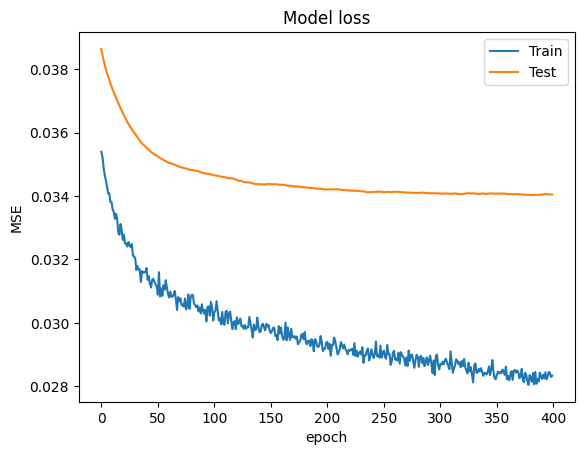

In [14]:
plt.plot(history.history['loss'])
plt.plot(np.array(history.history['val_loss']))
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [15]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

#calculating error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

6/6 [==============================] - 0s 22ms/step
Train Score: 0.70 RMSE
Test Score: 0.73 RMSE


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 500)               771000    
                                                                 
 dense (Dense)               (None, 250)               125250    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                12550     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                612       
                                                                 
Total params: 909412 (3.47 MB)
Trainable params: 909412 